# Transfer learning with PyTorch
We're going to train a neural network to classify dogs and cats.

## Init, helpers, utils, ...

In [1]:
from pprint import pprint
import random
import datetime
import time

from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import os

import torchvision
from torchvision.datasets.folder import ImageFolder, default_loader

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Training helpers
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

# The Data - DogsCatsDataset

## Transforms

In [4]:
from torchvision import transforms

IMG_SIZE = 224  #224  #defined by NN model input
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)  # some images are pretty small
    #transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),  #256  #(IMG_SIZE, IMG_SIZE)
    #transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

## Dataset

In [5]:
# change current working path to the root folder of this project

# root_path = os.path.abspath(os.pardir)

# os.chdir(root_path)

train_ds = ImageFolder("data/raw/DUI/train", transform=train_trans, loader=default_loader)
val_ds = ImageFolder("data/raw/DUI/valid", transform=train_trans, loader=default_loader)

BATCH_SIZE = 128  #2  #256  #512  #32  #220 for resnet152 on Dell Presison 5520 laptop, 400 for resnet18

n_classes = 2

from torch.utils.data import DataLoader

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=32,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=32,
)

13787 1421


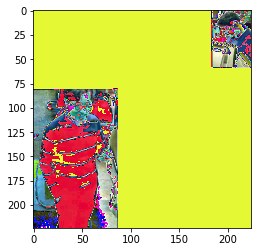

In [6]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(val_ds[4][0])

imgplot = plt.imshow(img)
print(len(train_ds), len(val_ds))

In [7]:
# add our new model for three inputs

from network.ResNet_ronorigin import *
model = resnet_18(nc=2)

for param in model.parameters():
    param.requires_grad = True
    
# model = model.to(device)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

/home/tuo/anaconda3/envs/torch36/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


# The Optimizer

In [8]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    # model.fc.parameters(),
    lr=0.001,
    momentum=0.9,
)

# The Train Loop

In [9]:
N_EPOCHS = 10  #1  #2  #10

In [10]:
for epoch in range(N_EPOCHS):
    
    # start epoch
    start_time = time.time()
    start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f'  Start Time: {start_datetime}')
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        # for example batch size = 32
        # torch tensor X.size 32 x 3 x 1536 x 512
        # torch tensor y.size 32 x 1
        X1 = X[:,:,:512,:]
        X2 = X[:,:,:512,:]
        X3 = X[:,:,:512,:]
        X1,X2,X3, y = X1.to(device),X2.to(device),X3.to(device), y.to(device) # to gpu
        
        
        optimizer.zero_grad()
        # with torch.set_grad_enabled(True):
        y_ = model(X1,X2,X3)
        loss = criterion(y_, y)
        # train + loss optim y_ tensor (0:0.3,1:0.7)==>batchsize x [0.3 0.7]
        loss.backward()
        optimizer.step()
        
        # Statistics
        print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
                    
            y_ = model(X)
            # softmax batchsize x [0.3 0.7] 
            # 0: batch, 1: argmax ==> choose a max item, ith
            _, y_label_ = torch.max(y_, 1)
            # ==> 1
            correct += (y_label_ == y).sum().item()
            
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")
    
    # end epoch
    end_time = time.time()
    end_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    time_elapsed = end_time - start_time
    datetime_elapsed = str(datetime.timedelta(seconds = time_elapsed))
    print(f'  End Time: {end_datetime}')
    print(f'  Time Elapsed: {datetime_elapsed}')
    print()

Epoch 1/10
  Start Time: 2019-02-05 15:17:16
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 5.051
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 2.363
torch.Size([64, 512])torch.Size([64, 512])

    batch loss: 1.043
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.385
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.508
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.483
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.610
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.525
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.359
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.501
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.538
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.427
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.414
torch.Size([64, 512])
torch.Size([64, 512])
    batch loss: 0.570
torch.Size([64, 512])
torch.Siz

Process Process-29:
Process Process-4:
Process Process-12:
Process Process-7:
Process Process-13:
Process Process-26:
Process Process-21:
Process Process-22:
Process Process-30:
Process Process-20:
Process Process-1:
Process Process-17:
Process Process-14:
Process Process-16:
Process Process-23:
Process Process-32:
Process Process-3:
Process Process-31:
Process Process-15:
Process Process-8:
Process Process-19:
Process Process-5:
Process Process-2:
Process Process-24:
Process Process-11:
Process Process-9:
Process Process-27:
Process Process-25:
Process Process-18:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trac

KeyboardInterrupt: 

** -- above is the result of crop extent data set -- **

# Predict with Trained Model

Pickle the trained model and predict image with it. 

In [ ]:
# save the trained model weights
import os

root_path = os.path.abspath(os.pardir)

model_weights_path = root_path+'/data/saved_model_weights/resnet18_whole'

# !!!only use it when you WANT to save a trained model weights!!!
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# load the trained model
from nets.ResNet_ronorigin import *
model = resnet_18()

for param in model.parameters():
    param.requires_grad = True
    
model = model.to(device)

model.load_state_dict(torch.load(model_weights_path))

In [ ]:
# use trained model to predict a pair of people in a new image

# test data set
test_ds = ImageFolder(root_path+"/data/raw/DUI/test", transform=val_trans, loader=default_loader)
print(f'len(test_ds) = {len(test_ds)}. ')

test_dl = DataLoader(
    test_ds,xx
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

print(f'test_ds[99]: \n{test_ds[99]}')
print(f'test_ds[99][1]: \n{test_ds[99][1]}')

In [ ]:
# predict

# Eval
model.eval()  # IMPORTANT

with torch.no_grad():  # IMPORTANT
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        print(f'y: \t\t\t{y}')

        y_ = model(X)
        _, y_label_ = torch.max(y_, 1)
        print(f'y_label_: \t\t{y_label_}')
        
        is_correct = 'correct' if y_label_ == y else 'wrong'
        print(f'is_correct: \t{is_correct}\n')

#print(f"  Valid Loss: {running_loss / len(val_dl.dataset)}")
#print(f"  Valid Acc:  {correct / len(val_dl.dataset)}")

In [ ]:
import torch
x = (torch.rand(3, 4) * 100).int()
y = (torch.rand(3, 5) * 100).int()
out = torch.cat((x, y), 1)
print(out.shape)